In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
num_classes = 10
epochs = 20

fashionmnist
t10k-images-idx3-ubyte
t10k-labels-idx1-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte



**Create dataframes for train and test datasets**

**Data Loading**

In [3]:
#Use this when you want to use the dataset in its original form.
'''
train_df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv', sep = ',')
print("Data has been loaded")
'''

'\ntrain_df = pd.read_csv(\'../input/fashionmnist/fashion-mnist_train.csv\',sep=\',\')\ntest_df = pd.read_csv(\'../input/fashionmnist/fashion-mnist_test.csv\', sep = \',\')\nprint("Data has been loaded")\n'

In [4]:
#Use this when you want to specify the number of images of each class to be considered for training. This can be modified to make it more irregular.
import pandas as pd
from sklearn.utils import shuffle

# Load the Fashion MNIST dataset CSV files
train_df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv', sep=',')
test_df = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv', sep=',')

# Define the number of images to select from each group of classes
NUM_IMAGES_FIRST_GROUP = 5000  # For class labels 0 to 4
NUM_IMAGES_SECOND_GROUP = 4000  # For class labels 5 to 9

# Sample a fixed number of images per class group from train_df
train_dfs_per_group = []
for class_label in range(10):  # There are 10 classes (0 to 9)
    if class_label <= 4:
        num_images = NUM_IMAGES_FIRST_GROUP
    else:
        num_images = NUM_IMAGES_SECOND_GROUP
    
    class_df = train_df[train_df['label'] == class_label].sample(n=num_images, replace=True, random_state=42)
    train_dfs_per_group.append(class_df)

# Concatenate sampled dataframes
train_df = pd.concat(train_dfs_per_group, ignore_index=True)

# Shuffle the concatenated dataframe
train_df = shuffle(train_df, random_state=42)

# Print the new class distribution
print("Train Set Class Distribution:")
print(train_df['label'].value_counts())

Train Set Class Distribution:
1    5000
2    5000
3    5000
0    5000
4    5000
8    4000
9    4000
5    4000
6    4000
7    4000
Name: label, dtype: int64


**Data Distribution Analysis**

In [5]:
class_counts = np.bincount(train_df['label'].values)
print("The number of images in each train class is - ",class_counts)

The number of images in each train class is -  [5000 5000 5000 5000 5000 4000 4000 4000 4000 4000]


In [6]:
class_counts = np.bincount(test_df['label'].values)
print("The number of images in each test class is - ",class_counts)

The number of images in each test class is -  [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


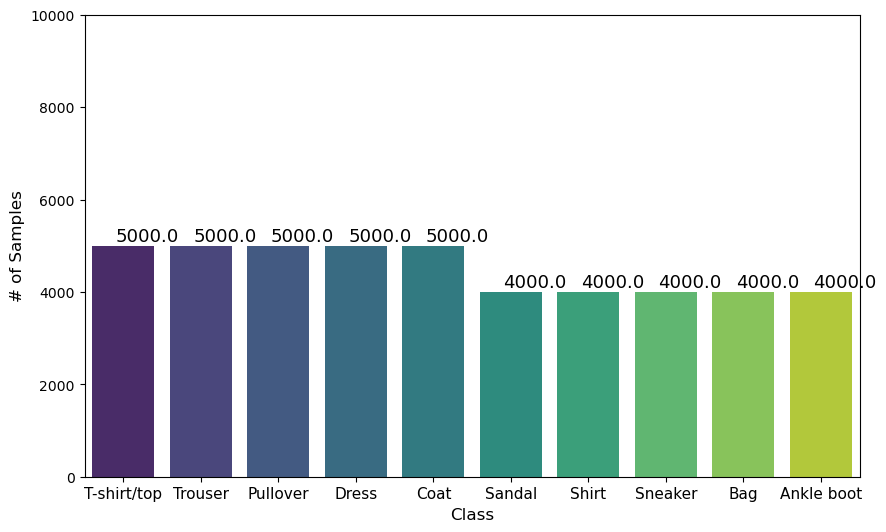

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Increased figsize for better display of all labels

# Create the count plot
ax = sns.countplot(x='label', data=train_df, palette='viridis')

# Set the labels and titles
plt.xlabel("Class", fontsize=12)
plt.ylabel("# of Samples", fontsize=12)
plt.ylim(0, 10000)

# Correct the xticks to match the number of classes
plt.xticks(range(10), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], fontsize=11)

# Annotate each bar with the height value
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.30, p.get_height() + 100), fontsize=13)

# Show the plot
plt.show()


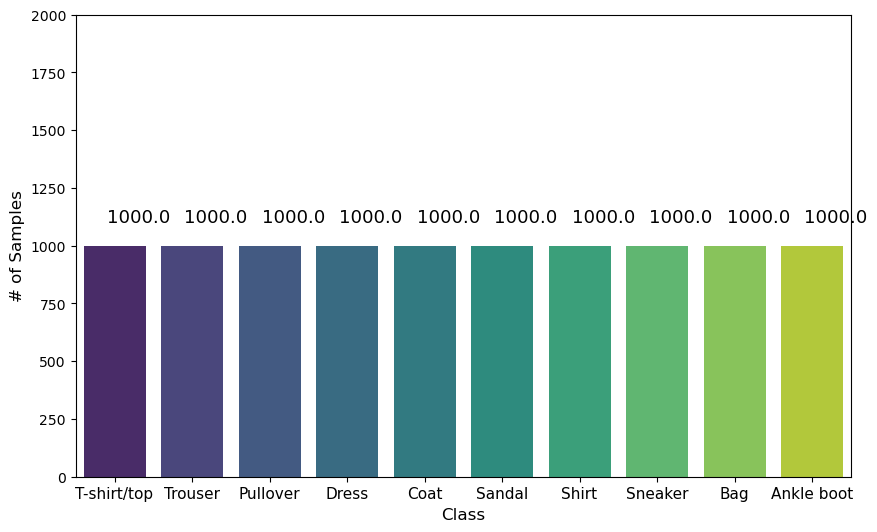

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Increased figsize for better display of all labels

# Create the count plot
ax = sns.countplot(x='label', data=test_df, palette='viridis')

# Set the labels and titles
plt.xlabel("Class", fontsize=12)
plt.ylabel("# of Samples", fontsize=12)
plt.ylim(0, 2000)

# Correct the xticks to match the number of classes
plt.xticks(range(10), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], fontsize=11)

# Annotate each bar with the height value
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.30, p.get_height() + 100), fontsize=13)

# Show the plot
plt.show()


Let us explore the train and test data

In [9]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
37979,8,0,0,0,0,0,1,0,4,2,...,0,0,0,0,0,0,2,0,0,0
9911,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
43386,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13822,2,0,0,0,0,0,0,0,0,0,...,2,5,0,0,130,179,49,0,0,0
44810,9,0,0,0,0,0,0,0,0,0,...,27,52,39,40,42,38,13,0,0,0


In [10]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now it is observed that the first column is the label data and because it has 10 classes so it is going to have from 0 to 9.The remaining columns are the actual pixel data.Here as you can see there are about 784 columns that contain pixel data.
Here each row is a different image representation in the form pixel data.

Now let us split the train data into x and y arrays where x represents the image data and y represents the labels.

To do that we need to convert the dataframes into numpy arrays of float32 type which is the acceptable form for tensorflow and keras.

In [11]:
train_data = np.array(train_df, dtype = 'float32')

Similarly let us do the same process for test data

In [12]:
test_data = np.array(test_df, dtype='float32')

Now let us slice the train arrays into x and y arrays namely x_train,y_train to store all image data and label data respectively.
i.e 

- x_train contains all the rows and all columns except the label column and excluding header info .
- y_train contains all the rows and first column and excluding header info .


Similarly slice the test arrays into x and y arrays namely x_train,y_train to store all image data and label data respectively.
i.e 

- x_test contains all the rows and all columns except the label column and excluding header info .
- y_test contains all the rows and first column and excluding header info .

####  Important Note : Since the image data in x_train and x_test is from 0 to 255 ,  we need to rescale this from 0 to 1.To do this we need to divide the x_train and x_test by 255 . It's important that the training set and the testing set be preprocessed in the same way:

In [13]:
x_train = train_data[:,1:]/255

y_train = train_data[:,0]

x_test= test_data[:,1:]/255

y_test=test_data[:,0]

Now we are gonna split the training data into validation and actual training data for training the model and testing it using the validation set. This is achieved using the train_test_split method of scikit learn library.

In [14]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)

Now let us visualise the some samples after the resize of the data which needs to be ready for train the network .


**Data Visualisation**

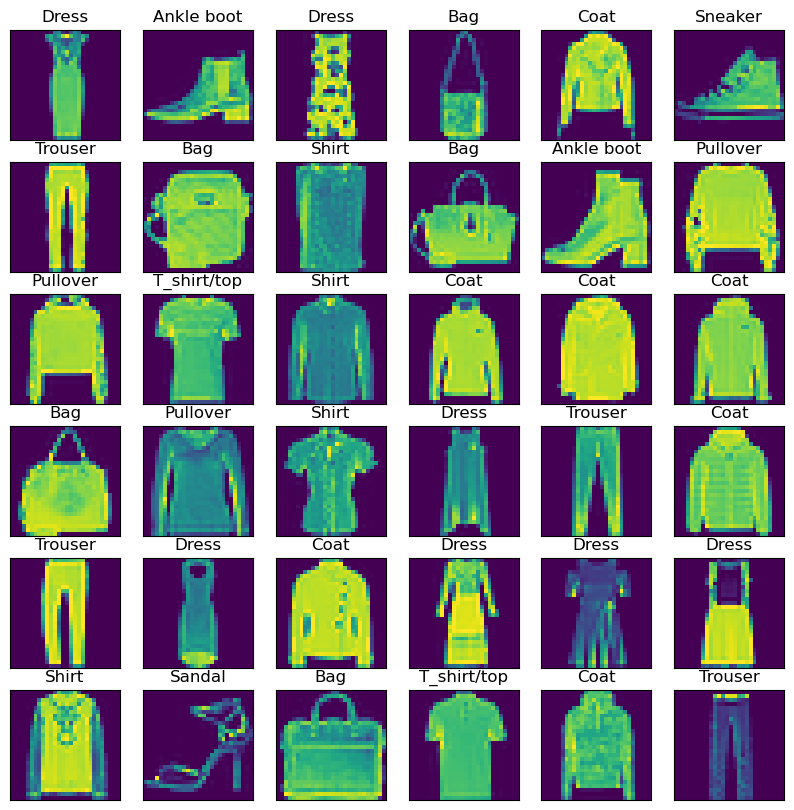

In [15]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28,28)))
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()

Labels
Each training and test example is assigned to one of the following labels as shown below:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

I think the best way is to visualise the above 10 types of classes to get a feel of what these items look like :) .So let us visualise


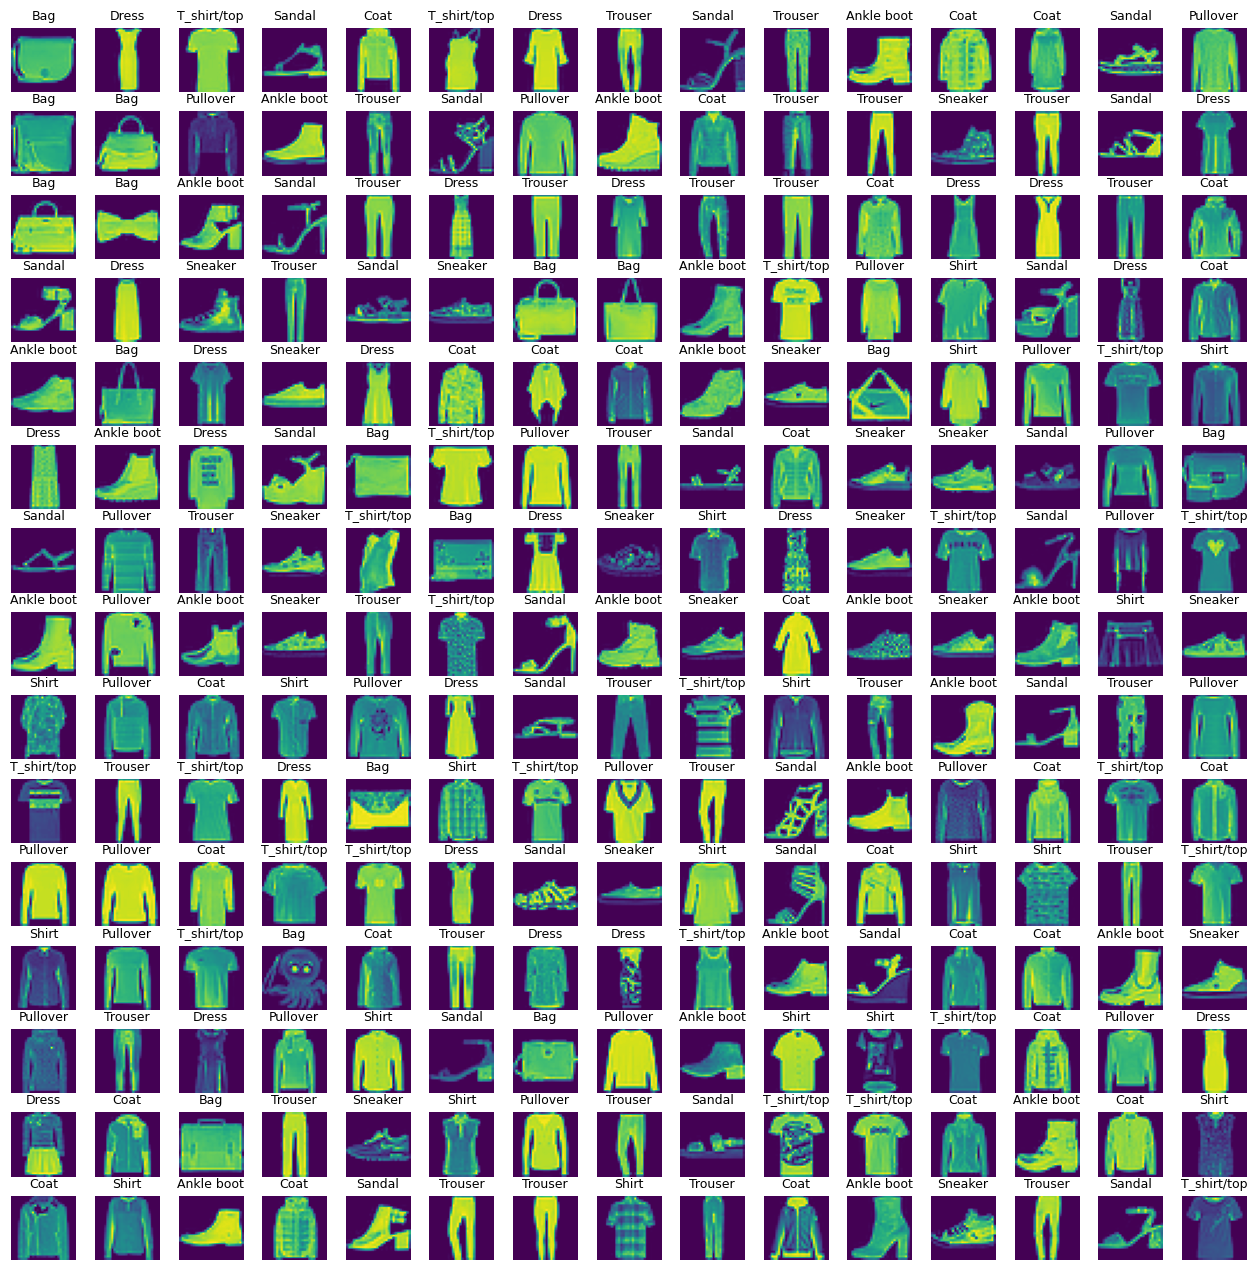

In [16]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (16,16))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(train_data) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow( train_data[index,1:].reshape((28,28)) )
    labelindex = int(train_data[index,0])
    axes[i].set_title(class_names[labelindex], fontsize = 9)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

As you can observe above the shape of shoe from the sample image

### Create the Convolutional Neural Networks (CNN)

#### Define model

#### Compile model

#### Train model

First of all let us define the shape of the image before we define the model. Defined the shape of the image as 3d with rows and columns and 1 for the 3d visualisation


In [17]:
image_rows = 28
image_cols = 28
batch_size = 4096
image_shape = (image_rows,image_cols,1) 

Now we need to do more formating on the x_train,x_test and x_validate sets.

In [18]:
x_train = x_train.reshape(x_train.shape[0],*image_shape)
x_test = x_test.reshape(x_test.shape[0],*image_shape)
x_validate = x_validate.reshape(x_validate.shape[0],*image_shape)

#### Define the model 

The first layer in model network, keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). This layer unstacks rows of pixels in the image and lining them up and has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 32 nodes (or neurons). The second (and last) layer is a 10-node softmax layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

**Model Architecture**

In [19]:
cnn_model = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(32,activation='relu'),
    Dense(10,activation = 'softmax')
    
])
'''
cnn_model = Sequential([
        # Block One
        Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=image_shape),
        MaxPooling2D(pool_size=2),
        Dropout(0.2),
        
        # Block Two
        Conv2D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2),
        Dropout(0.2),
        
        # Block Three
        Conv2D(filters=128, kernel_size=3, activation='relu'),
        Dropout(0.2),  # Remove pooling layer to prevent excessive downsampling
        
        # Block Four
        Conv2D(filters=256, kernel_size=3, activation='relu'),
        Dropout(0.2),  # Remove pooling layer to prevent excessive downsampling
        
        # Flatten and Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # Assuming 10 classes for classification, adjust accordingly
    ])
'''

"\ncnn_model = Sequential([\n        # Block One\n        Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=image_shape),\n        MaxPooling2D(pool_size=2),\n        Dropout(0.2),\n        \n        # Block Two\n        Conv2D(filters=64, kernel_size=3, activation='relu'),\n        MaxPooling2D(pool_size=2),\n        Dropout(0.2),\n        \n        # Block Three\n        Conv2D(filters=128, kernel_size=3, activation='relu'),\n        Dropout(0.2),  # Remove pooling layer to prevent excessive downsampling\n        \n        # Block Four\n        Conv2D(filters=256, kernel_size=3, activation='relu'),\n        Dropout(0.2),  # Remove pooling layer to prevent excessive downsampling\n        \n        # Flatten and Dense layers\n        Flatten(),\n        Dense(64, activation='relu'),\n        Dropout(0.5),\n        Dense(10, activation='softmax')  # Assuming 10 classes for classification, adjust accordingly\n    ])\n"

#### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

* Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.Here we will use "sparse_categorical_crossentropy"
* Optimizer —This is how the model is updated based on the data it sees and its loss function.
* Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [20]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [21]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 32)                173088    
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                        

#### Train Model:
Training the neural network model requires the following steps:

* Feed the training data to the model. In this example, the training data is in the x_train and y_train arrays.
* The model learns to associate images and labels.
* You ask the model to make predictions about a test set—in this example, the x_test array. Verify that the predictions match the labels from the y_test array.

To start training, call the model.fit method—so called because it "fits" the model to the training data:

**Training the model**

In [22]:
history = cnn_model.fit(
    x_train,
    y_train,
    batch_size=4096,
    epochs=75,
    verbose=1,
    validation_data=(x_validate,y_validate),
)

Epoch 1/75
9/9 [==============================] - 1s 146ms/step - loss: 1.9037 - accuracy: 0.4496 - val_loss: 1.3887 - val_accuracy: 0.6497
Epoch 2/75
9/9 [==============================] - 1s 138ms/step - loss: 1.1423 - accuracy: 0.6707 - val_loss: 0.8996 - val_accuracy: 0.7077
Epoch 3/75
9/9 [==============================] - 1s 143ms/step - loss: 0.8159 - accuracy: 0.7304 - val_loss: 0.7154 - val_accuracy: 0.7607
Epoch 4/75
9/9 [==============================] - 2s 165ms/step - loss: 0.6868 - accuracy: 0.7728 - val_loss: 0.6255 - val_accuracy: 0.7887
Epoch 5/75
9/9 [==============================] - 1s 137ms/step - loss: 0.6106 - accuracy: 0.7949 - val_loss: 0.5685 - val_accuracy: 0.8077
Epoch 6/75
9/9 [==============================] - 1s 140ms/step - loss: 0.5629 - accuracy: 0.8105 - val_loss: 0.5399 - val_accuracy: 0.8162
Epoch 7/75
9/9 [==============================] - 1s 134ms/step - loss: 0.5279 - accuracy: 0.8206 - val_loss: 0.5153 - val_accuracy: 0.8252
Epoch 8/75
9/9 [====

9/9 [==============================] - 1s 133ms/step - loss: 0.2581 - accuracy: 0.9099 - val_loss: 0.2855 - val_accuracy: 0.9014
Epoch 60/75
9/9 [==============================] - 1s 135ms/step - loss: 0.2553 - accuracy: 0.9106 - val_loss: 0.2901 - val_accuracy: 0.8994
Epoch 61/75
9/9 [==============================] - 1s 134ms/step - loss: 0.2548 - accuracy: 0.9094 - val_loss: 0.2880 - val_accuracy: 0.8979
Epoch 62/75
9/9 [==============================] - 1s 146ms/step - loss: 0.2554 - accuracy: 0.9097 - val_loss: 0.2854 - val_accuracy: 0.8994
Epoch 63/75
9/9 [==============================] - 1s 134ms/step - loss: 0.2514 - accuracy: 0.9125 - val_loss: 0.2793 - val_accuracy: 0.9031
Epoch 64/75
9/9 [==============================] - 1s 132ms/step - loss: 0.2504 - accuracy: 0.9141 - val_loss: 0.2842 - val_accuracy: 0.8989
Epoch 65/75
9/9 [==============================] - 1s 135ms/step - loss: 0.2480 - accuracy: 0.9123 - val_loss: 0.2787 - val_accuracy: 0.9004
Epoch 66/75
9/9 [========

Let us plot the Training Accuracy vs Loss to get a better understanding of the model training.

Text(0.5, 1.0, 'Training - Accuracy')

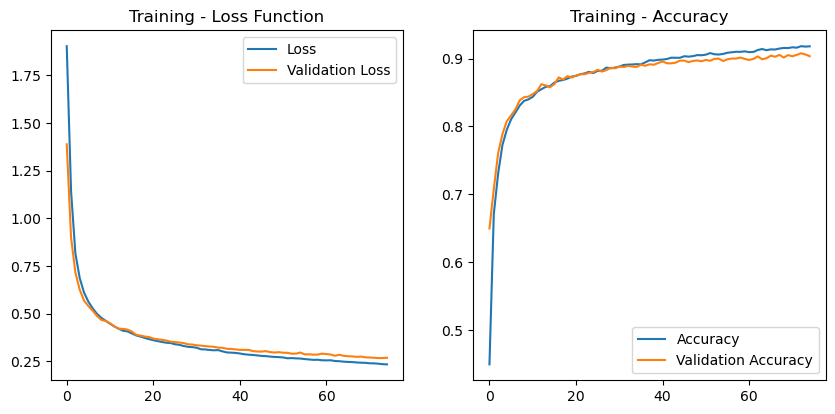

In [23]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training - Accuracy')

- #### Evaluate /Score the model

In [24]:
score = cnn_model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2971
Test Accuracy : 0.8994


### Results




Let's plot training and validation accuracy as well as loss.

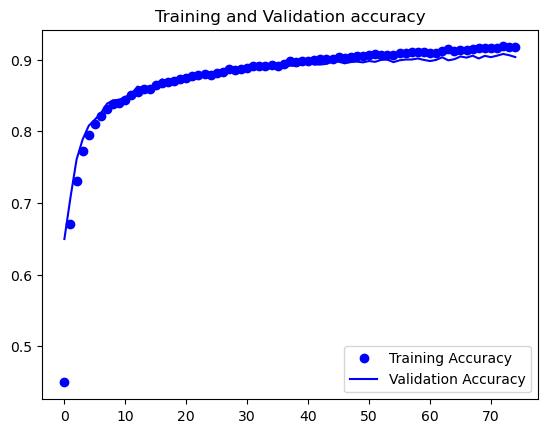

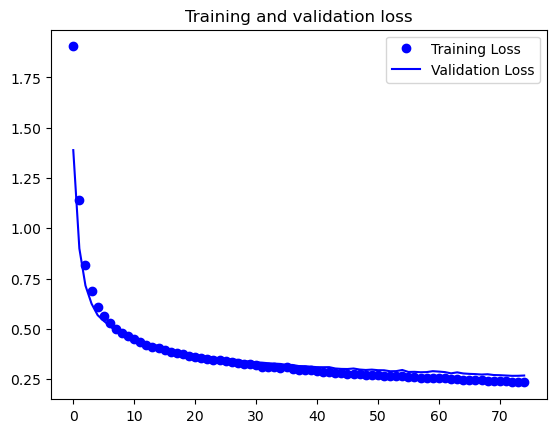

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Classification Report
We can summarize the performance of our classifier as follows

In [26]:
#Get the predictions for the test data
predicted_classes = np.argmax(cnn_model.predict(x_test), axis=1)
#Get the indices to be plotted
y_true = test_df.iloc[:, 0].values
correct = np.where(predicted_classes==y_true)[0]
incorrect = np.where(predicted_classes!=y_true)[0]
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

     Class 0       0.79      0.89      0.84      1000
     Class 1       0.99      0.98      0.98      1000
     Class 2       0.84      0.86      0.85      1000
     Class 3       0.91      0.93      0.92      1000
     Class 4       0.83      0.90      0.86      1000
     Class 5       0.98      0.95      0.97      1000
     Class 6       0.80      0.60      0.68      1000
     Class 7       0.93      0.95      0.94      1000
     Class 8       0.97      0.97      0.97      1000
     Class 9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



It's apparent that our classifier is underperforming for class 6 in terms of both precision and recall. For class 2, classifier is slightly lacking precision whereas it is slightly lacking recall (i.e. missed) for class 4.

Perhaps we would gain more insight after visualizing the correct and incorrect predictions.

Let us examine the test label and check if it the right classification or not.

**Prediction Visualisation**

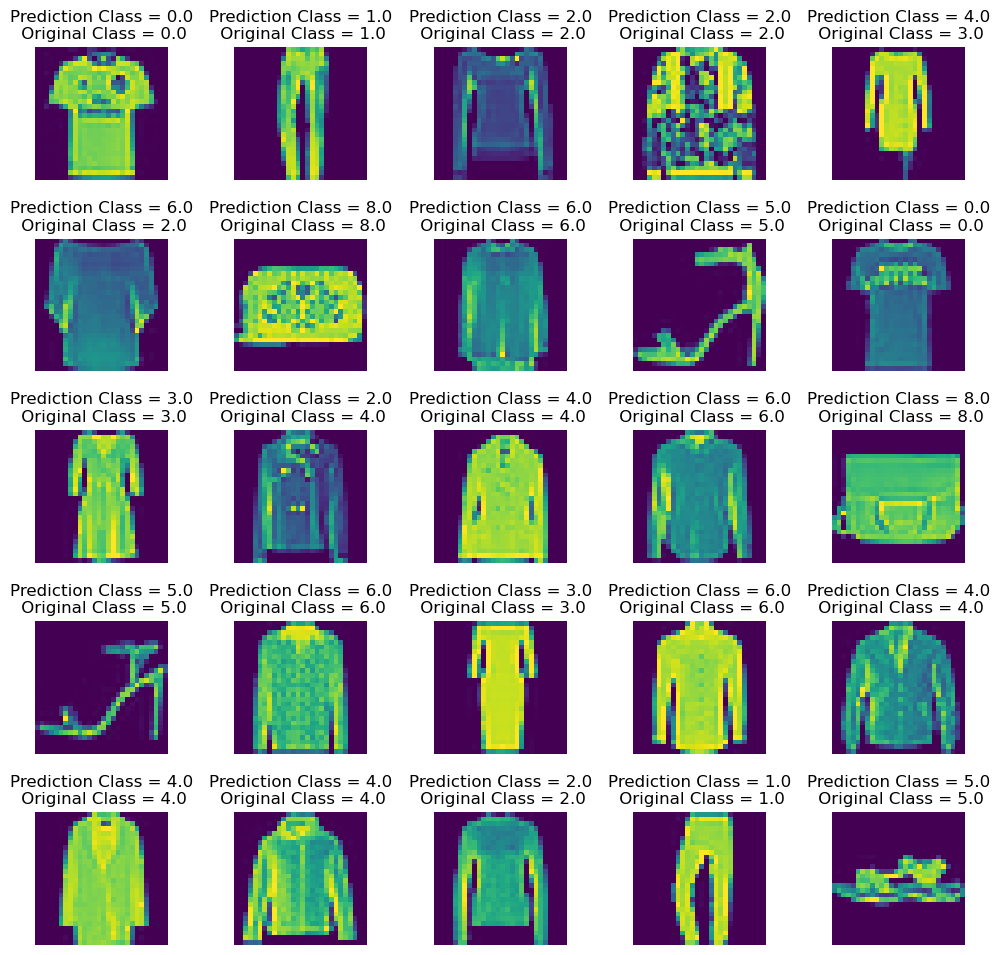

In [27]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(x_test[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]:0.1f}\n Original Class = {y_test[i]:0.1f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

313/313 [==============================] - 1s 2ms/step
Average AUROC: 0.993


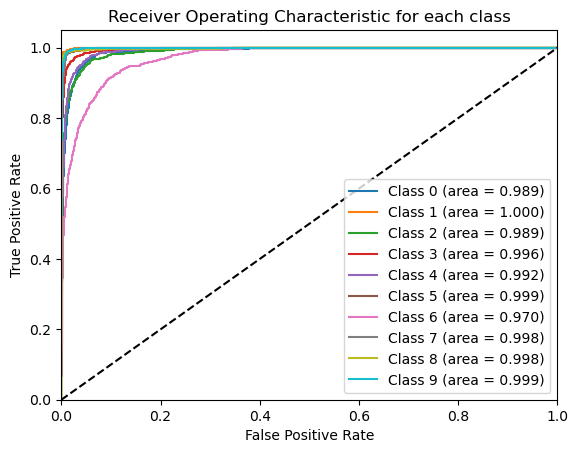

Class 0:
  Sensitivity (Recall): 0.876
  Specificity: 0.980
Class 1:
  Sensitivity (Recall): 0.978
  Specificity: 0.998
Class 2:
  Sensitivity (Recall): 0.854
  Specificity: 0.984
Class 3:
  Sensitivity (Recall): 0.937
  Specificity: 0.989
Class 4:
  Sensitivity (Recall): 0.867
  Specificity: 0.986
Class 5:
  Sensitivity (Recall): 0.962
  Specificity: 0.997
Class 6:
  Sensitivity (Recall): 0.704
  Specificity: 0.976
Class 7:
  Sensitivity (Recall): 0.946
  Specificity: 0.994
Class 8:
  Sensitivity (Recall): 0.965
  Specificity: 0.998
Class 9:
  Sensitivity (Recall): 0.969
  Specificity: 0.994
Average Sensitivity: 0.906
Average Specificity: 0.990


In [72]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_pred_prob = cnn_model.predict(x_test)

# Binarize the true labels
y_true_binarized = label_binarize(y_test, classes=np.arange(10))

# Calculate AUROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):  # 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUROC
average_auc = np.mean(list(roc_auc.values()))
print(f'Average AUROC: {average_auc:.3f}')

# Plot ROC curve for each class
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower right')
plt.show()

# Compute sensitivity and specificity for each class
sensitivity_list = []
specificity_list = []

for i in range(10):
    y_true_binary = (y_test == i).astype(int)
    y_pred_binary = (np.argmax(y_pred_prob, axis=1) == i).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
    else:
        sensitivity = 0.0
        specificity = 0.0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f'Class {i}:')
    print(f'  Sensitivity (Recall): {sensitivity:.3f}')
    print(f'  Specificity: {specificity:.3f}')

# Calculate average sensitivity and specificity across all classes
average_sensitivity = np.mean(sensitivity_list)
average_specificity = np.mean(specificity_list)

print(f'Average Sensitivity: {average_sensitivity:.3f}')
print(f'Average Specificity: {average_specificity:.3f}')


# **POST TRAINING QUANTISATION**

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Preprocess the images: Normalize the pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape the images to add a channel dimension
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

model = cnn_model

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Define the representative dataset generator
def representative_dataset_gen():
    for input_sample in train_images[:100]:  # Use the first 100 samples for calibration
        # Expand dims to add batch size of 1
        input_sample = np.expand_dims(input_sample, axis=0).astype(np.float32)
        yield [input_sample]

# Set the optimizations and representative dataset
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

# Convert the model
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/k4/gczjyz2n3wqg55mfxfkq7mkr0000gn/T/tmpkrxx6nnq/assets


INFO:tensorflow:Assets written to: /var/folders/k4/gczjyz2n3wqg55mfxfkq7mkr0000gn/T/tmpkrxx6nnq/assets
2024-07-07 10:39:12.250609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-07-07 10:39:12.250620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-07-07 10:39:12.250717: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/k4/gczjyz2n3wqg55mfxfkq7mkr0000gn/T/tmpkrxx6nnq
2024-07-07 10:39:12.251278: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-07-07 10:39:12.251288: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/k4/gczjyz2n3wqg55mfxfkq7mkr0000gn/T/tmpkrxx6nnq
2024-07-07 10:39:12.252687: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-07-07 10:39:12.269993: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

In [42]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Evaluate the model on the test set
correct_predictions = 0

for i in range(len(test_images)):
    input_data = np.expand_dims(test_images[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output_data)
    true_label = test_labels[i]
    if predicted_label == true_label:
        correct_predictions += 1

accuracy = correct_predictions / len(test_images)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8983


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Average AUROC: 0.992


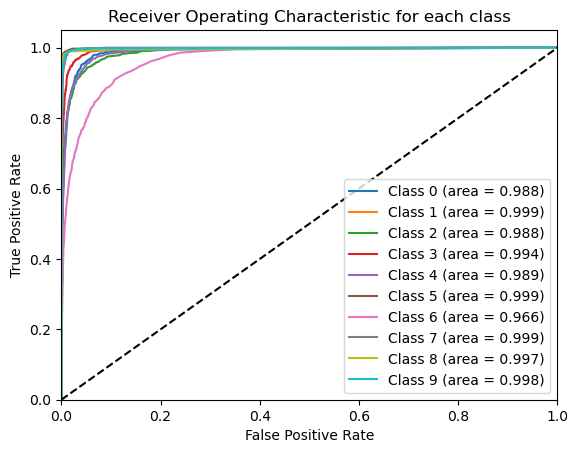

Class 0:
  Sensitivity (Recall): 0.910
  Specificity: 0.973
Class 1:
  Sensitivity (Recall): 0.970
  Specificity: 0.999
Class 2:
  Sensitivity (Recall): 0.870
  Specificity: 0.978
Class 3:
  Sensitivity (Recall): 0.924
  Specificity: 0.988
Class 4:
  Sensitivity (Recall): 0.869
  Specificity: 0.980
Class 5:
  Sensitivity (Recall): 0.969
  Specificity: 0.998
Class 6:
  Sensitivity (Recall): 0.581
  Specificity: 0.987
Class 7:
  Sensitivity (Recall): 0.958
  Specificity: 0.993
Class 8:
  Sensitivity (Recall): 0.973
  Specificity: 0.997
Class 9:
  Sensitivity (Recall): 0.959
  Specificity: 0.996
Average Sensitivity: 0.898
Average Specificity: 0.989


In [73]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get the predicted probabilities for each class from the TFLite model
y_pred = np.zeros((len(test_images), 10))  # Assuming 10 classes

for i in range(len(test_images)):
    input_data = np.expand_dims(test_images[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details[0]['index'])

# Binarize the output labels
y_true_binarized = label_binarize(test_labels, classes=np.arange(10))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUC
average_auc = np.mean(list(roc_auc.values()))
print(f'Average AUROC: {average_auc:.3f}')

# Plot ROC curve for each class
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower right')
plt.show()

# Compute sensitivity and specificity for each class
sensitivity_list = []
specificity_list = []

for i in range(10):
    y_true_binary = (test_labels == i).astype(int)
    y_pred_binary = (np.argmax(y_pred, axis=1) == i).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
    else:
        sensitivity = 0.0
        specificity = 0.0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f'Class {i}:')
    print(f'  Sensitivity (Recall): {sensitivity:.3f}')
    print(f'  Specificity: {specificity:.3f}')

# Calculate average sensitivity and specificity across all classes
average_sensitivity = np.mean(sensitivity_list)
average_specificity = np.mean(specificity_list)

print(f'Average Sensitivity: {average_sensitivity:.3f}')
print(f'Average Specificity: {average_specificity:.3f}')


# **Quantization Aware Training**

In [60]:
import tensorflow_model_optimization as tfmot
qat_model = tfmot.quantization.keras.quantize_model(cnn_model)

In [61]:
qat_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [63]:
qat_model.fit(
    x_train,
    y_train,
    batch_size=4096,
    epochs=75,
    verbose=1,
    validation_data=(x_validate,y_validate),
)

Epoch 1/75
9/9 [==============================] - 2s 220ms/step - loss: 0.1524 - accuracy: 0.9669 - val_loss: 0.5091 - val_accuracy: 0.9111
Epoch 2/75
9/9 [==============================] - 2s 223ms/step - loss: 0.1403 - accuracy: 0.9681 - val_loss: 0.4931 - val_accuracy: 0.9131
Epoch 3/75
9/9 [==============================] - 2s 221ms/step - loss: 0.1321 - accuracy: 0.9699 - val_loss: 0.4833 - val_accuracy: 0.9136
Epoch 4/75
9/9 [==============================] - 2s 230ms/step - loss: 0.1338 - accuracy: 0.9708 - val_loss: 0.4754 - val_accuracy: 0.9132
Epoch 5/75
9/9 [==============================] - 2s 226ms/step - loss: 0.1233 - accuracy: 0.9721 - val_loss: 0.4691 - val_accuracy: 0.9148
Epoch 6/75
9/9 [==============================] - 2s 236ms/step - loss: 0.1203 - accuracy: 0.9712 - val_loss: 0.4653 - val_accuracy: 0.9144
Epoch 7/75
9/9 [==============================] - 2s 239ms/step - loss: 0.1193 - accuracy: 0.9725 - val_loss: 0.4604 - val_accuracy: 0.9147
Epoch 8/75
9/9 [====

9/9 [==============================] - 2s 236ms/step - loss: 0.0768 - accuracy: 0.9786 - val_loss: 0.3686 - val_accuracy: 0.9232
Epoch 60/75
9/9 [==============================] - 2s 243ms/step - loss: 0.0751 - accuracy: 0.9779 - val_loss: 0.3691 - val_accuracy: 0.9230
Epoch 61/75
9/9 [==============================] - 2s 230ms/step - loss: 0.0771 - accuracy: 0.9784 - val_loss: 0.3683 - val_accuracy: 0.9239
Epoch 62/75
9/9 [==============================] - 2s 229ms/step - loss: 0.0732 - accuracy: 0.9787 - val_loss: 0.3677 - val_accuracy: 0.9236
Epoch 63/75
9/9 [==============================] - 2s 233ms/step - loss: 0.0729 - accuracy: 0.9794 - val_loss: 0.3689 - val_accuracy: 0.9233
Epoch 64/75
9/9 [==============================] - 2s 233ms/step - loss: 0.0736 - accuracy: 0.9795 - val_loss: 0.3662 - val_accuracy: 0.9240
Epoch 65/75
9/9 [==============================] - 2s 237ms/step - loss: 0.0732 - accuracy: 0.9777 - val_loss: 0.3674 - val_accuracy: 0.9239
Epoch 66/75
9/9 [========

In [66]:
# Evaluate the QAT model
loss, accuracy = qat_model.evaluate(x_train,y_train, verbose=1)
print(f'QAT Model Accuracy: {accuracy:.3f}')

1125/1125 [==============================] - 2s 2ms/step - loss: 0.0417 - accuracy: 0.9894
QAT Model Accuracy: 0.989


313/313 [==============================] - 1s 2ms/step
Average AUROC: 0.999


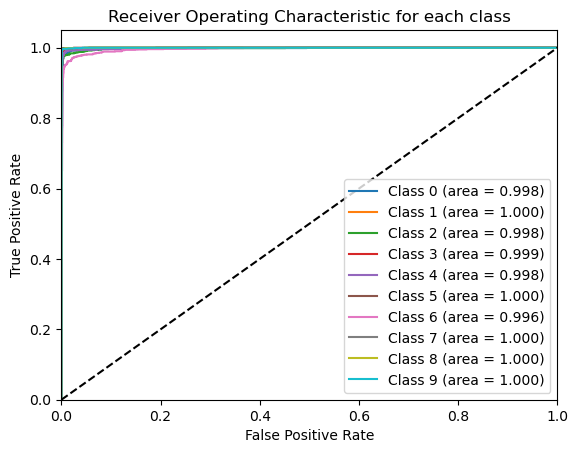

Class 0:
  Sensitivity (Recall): 0.985
  Specificity: 0.994
Class 1:
  Sensitivity (Recall): 0.997
  Specificity: 1.000
Class 2:
  Sensitivity (Recall): 0.967
  Specificity: 0.997
Class 3:
  Sensitivity (Recall): 0.989
  Specificity: 0.998
Class 4:
  Sensitivity (Recall): 0.976
  Specificity: 0.997
Class 5:
  Sensitivity (Recall): 0.997
  Specificity: 1.000
Class 6:
  Sensitivity (Recall): 0.926
  Specificity: 0.996
Class 7:
  Sensitivity (Recall): 0.990
  Specificity: 0.999
Class 8:
  Sensitivity (Recall): 0.994
  Specificity: 1.000
Class 9:
  Sensitivity (Recall): 0.993
  Specificity: 0.999
Average Sensitivity: 0.981
Average Specificity: 0.998


In [67]:
y_pred_prob = qat_model.predict(x_test)

# Binarize the true labels
y_true_binarized = label_binarize(y_test, classes=np.arange(10))

# Calculate AUROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):  # 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUROC
average_auc = np.mean(list(roc_auc.values()))
print(f'Average AUROC: {average_auc:.3f}')

# Plot ROC curve for each class
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower right')
plt.show()

# Compute sensitivity and specificity for each class
sensitivity_list = []
specificity_list = []

for i in range(10):
    y_true_binary = (y_test == i).astype(int)
    y_pred_binary = (np.argmax(y_pred_prob, axis=1) == i).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
    else:
        sensitivity = 0.0
        specificity = 0.0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f'Class {i}:')
    print(f'  Sensitivity (Recall): {sensitivity:.3f}')
    print(f'  Specificity: {specificity:.3f}')

# Calculate average sensitivity and specificity across all classes
average_sensitivity = np.mean(sensitivity_list)
average_specificity = np.mean(specificity_list)

print(f'Average Sensitivity: {average_sensitivity:.3f}')
print(f'Average Specificity: {average_specificity:.3f}')


# **MIXED PRECISION TRAINING**

In [68]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [69]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
cnn_model.fit(
    x_train,
    y_train,
    batch_size=4096,
    epochs=75,
    verbose=1,
    validation_data=(x_validate,y_validate),
)

Epoch 1/75
9/9 [==============================] - 1s 137ms/step - loss: 0.3544 - accuracy: 0.8816 - val_loss: 0.2637 - val_accuracy: 0.9048
Epoch 2/75
9/9 [==============================] - 1s 131ms/step - loss: 0.2528 - accuracy: 0.9079 - val_loss: 0.2988 - val_accuracy: 0.8956
Epoch 3/75
9/9 [==============================] - 1s 131ms/step - loss: 0.2397 - accuracy: 0.9149 - val_loss: 0.2662 - val_accuracy: 0.9046
Epoch 4/75
9/9 [==============================] - 1s 133ms/step - loss: 0.2244 - accuracy: 0.9210 - val_loss: 0.2569 - val_accuracy: 0.9088
Epoch 5/75
9/9 [==============================] - 1s 141ms/step - loss: 0.2189 - accuracy: 0.9242 - val_loss: 0.2566 - val_accuracy: 0.9083
Epoch 6/75
9/9 [==============================] - 1s 137ms/step - loss: 0.2157 - accuracy: 0.9258 - val_loss: 0.2531 - val_accuracy: 0.9110
Epoch 7/75
9/9 [==============================] - 1s 138ms/step - loss: 0.2157 - accuracy: 0.9256 - val_loss: 0.2533 - val_accuracy: 0.9124
Epoch 8/75
9/9 [====

9/9 [==============================] - 1s 132ms/step - loss: 0.1753 - accuracy: 0.9381 - val_loss: 0.2310 - val_accuracy: 0.9184
Epoch 60/75
9/9 [==============================] - 1s 131ms/step - loss: 0.1771 - accuracy: 0.9379 - val_loss: 0.2313 - val_accuracy: 0.9182
Epoch 61/75
9/9 [==============================] - 1s 132ms/step - loss: 0.1728 - accuracy: 0.9402 - val_loss: 0.2310 - val_accuracy: 0.9206
Epoch 62/75
9/9 [==============================] - 1s 131ms/step - loss: 0.1735 - accuracy: 0.9395 - val_loss: 0.2298 - val_accuracy: 0.9197
Epoch 63/75
9/9 [==============================] - 1s 131ms/step - loss: 0.1728 - accuracy: 0.9393 - val_loss: 0.2311 - val_accuracy: 0.9209
Epoch 64/75
9/9 [==============================] - 1s 132ms/step - loss: 0.1723 - accuracy: 0.9402 - val_loss: 0.2295 - val_accuracy: 0.9196
Epoch 65/75
9/9 [==============================] - 1s 131ms/step - loss: 0.1720 - accuracy: 0.9402 - val_loss: 0.2289 - val_accuracy: 0.9211
Epoch 66/75
9/9 [========

313/313 [==============================] - 0s 1ms/step
Average AUROC: 0.993


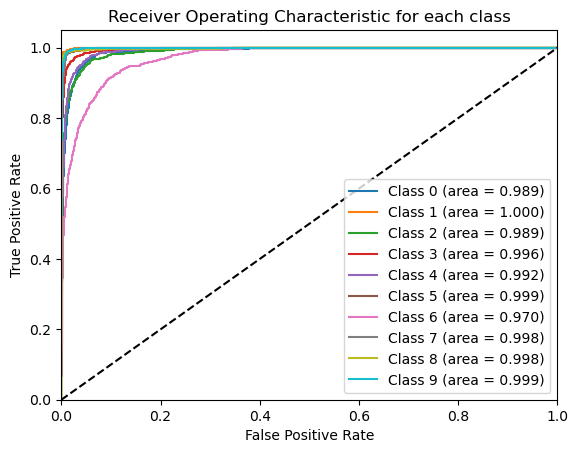

Class 0:
  Sensitivity (Recall): 0.876
  Specificity: 0.980
Class 1:
  Sensitivity (Recall): 0.978
  Specificity: 0.998
Class 2:
  Sensitivity (Recall): 0.854
  Specificity: 0.984
Class 3:
  Sensitivity (Recall): 0.937
  Specificity: 0.989
Class 4:
  Sensitivity (Recall): 0.867
  Specificity: 0.986
Class 5:
  Sensitivity (Recall): 0.962
  Specificity: 0.997
Class 6:
  Sensitivity (Recall): 0.704
  Specificity: 0.976
Class 7:
  Sensitivity (Recall): 0.946
  Specificity: 0.994
Class 8:
  Sensitivity (Recall): 0.965
  Specificity: 0.998
Class 9:
  Sensitivity (Recall): 0.969
  Specificity: 0.994
Average Sensitivity: 0.906
Average Specificity: 0.990


In [71]:
y_pred_prob = cnn_model.predict(x_test)

# Binarize the true labels
y_true_binarized = label_binarize(y_test, classes=np.arange(10))

# Calculate AUROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):  # 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average AUROC
average_auc = np.mean(list(roc_auc.values()))
print(f'Average AUROC: {average_auc:.3f}')

# Plot ROC curve for each class
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower right')
plt.show()

# Compute sensitivity and specificity for each class
sensitivity_list = []
specificity_list = []

for i in range(10):
    y_true_binary = (y_test == i).astype(int)
    y_pred_binary = (np.argmax(y_pred_prob, axis=1) == i).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
    else:
        sensitivity = 0.0
        specificity = 0.0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f'Class {i}:')
    print(f'  Sensitivity (Recall): {sensitivity:.3f}')
    print(f'  Specificity: {specificity:.3f}')

# Calculate average sensitivity and specificity across all classes
average_sensitivity = np.mean(sensitivity_list)
average_specificity = np.mean(specificity_list)

print(f'Average Sensitivity: {average_sensitivity:.3f}')
print(f'Average Specificity: {average_specificity:.3f}')
